In [460]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D

In [461]:
def calculateMetrics(y_test, y_pred):
    rmse = np.sqrt(np.mean((y_pred - y_test)*(y_pred - y_test)))
    mae = np.mean(np.abs(y_pred - y_test))
    mape = np.mean(np.abs(y_pred - y_test) / (y_test + 1e-0))
    # r2 = (np.corrcoef(y_pred, y_test)[0,1])**2
    r2 = r2_score(y_test, y_pred)

    print(f'RMSE: {rmse}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')
    print(f'R2: {r2}')

    # Calculate Pearson correlation coefficient
    pearson_corr, _ = pearsonr(y_test.flatten(), y_pred.flatten())
    print(f"Pearson correlation coefficient: {pearson_corr}")

    # Calculate Spearman correlation coefficient
    spearman_corr, _ = spearmanr(y_test.flatten(), y_pred.flatten())
    print(f"Spearman correlation coefficient: {spearman_corr}")

    return rmse, mae, mape, r2, pearson_corr, spearman_corr

In [462]:
df_original = pd.read_csv('../data/Wimbledon_featured_matches_modified_add_features.csv')

In [463]:
# hyper 
last_n = 5
pca_dim = 2
n_clusters = 3
match_id = 28
reduced_dim = 3

The high Pearson and Spearman correlation coefficients suggest a strong positive relationship between the two variables being analyzed. 

In the context of a match (like match 31 or match 5), this could mean that two aspects of the game (like player performance metrics, team statistics, etc.) move together. When one increases, the other tends to increase as well, and vice versa. 

However, without more context about what these two variables represent, it's hard to provide a more specific interpretation.

In [464]:
df_original['next_point_winner'] = df_original.groupby('set_id')['point_victor'].shift(-1, fill_value=1).astype(int)

In [465]:
df_final = df_original[df_original["match_id"] == match_id].reset_index(drop=True)

In [466]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 59 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   match_id             217 non-null    int64  
 1   player1              217 non-null    object 
 2   player2              217 non-null    object 
 3   elapsed_time         217 non-null    object 
 4   set_no               217 non-null    int64  
 5   game_no              217 non-null    int64  
 6   point_no             217 non-null    int64  
 7   p1_sets              217 non-null    int64  
 8   p2_sets              217 non-null    int64  
 9   p1_games             217 non-null    int64  
 10  p2_games             217 non-null    int64  
 11  p1_score             217 non-null    int64  
 12  p2_score             217 non-null    int64  
 13  server               217 non-null    int64  
 14  serve_no             217 non-null    int64  
 15  point_victor         217 non-null    int

In [467]:
# NP_relevant_columns = [
#     "p1_ace", 
#     "p2_ace",
#     "p1_winner",
#     "p2_winner",
#     "winner_shot_type",
#     "p1_double_fault",
#     "p2_double_fault",
#     "p1_unf_err",
#     "p2_unf_err",
#     "p1_net_pt",
#     "p2_net_pt",
#     "p1_net_pt_won",
#     "p2_net_pt_won",
#     "p1_break_pt",
#     "p2_break_pt",
#     "p1_break_pt_won",
#     "p2_break_pt_won",
#     "p1_break_pt_missed",
#     "p2_break_pt_missed",
#     "p1_distance_run",
#     "p2_distance_run",
#     "rally_count",
#     "speed_mph",
#     "serve_width",
#     "serve_depth",
#     "return_depth"
#     ]
p1_momentum_relevant_columns = [
    "critical_points_p1",
    "faults_p1",
    # "points_diff",
    "fatigue_p1",
    "server"
]
p2_momentum_relevant_columns = [
    "critical_points_p2",
    "faults_p2",
    # "points_diff",
    "fatigue_p2",
    "server"
]

df_NP_relevant = df_final[p1_momentum_relevant_columns]
# df_NP_relevant["points_diff"] *= -1


In [468]:
df_NP_relevant["fatigue_p1"].fillna(0, inplace=True)

/var/folders/m2/zcwxrgy51pn1nvmjxw69mj9h0000gn/T/ipykernel_21746/3299876754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NP_relevant["fatigue_p1"].fillna(0, inplace=True)


In [469]:
# last_n entries as one X entry
X = []

# last_n
# for i in range(last_n, len(df_NP_relevant)):
#     X.append(df_NP_relevant.iloc[i-last_n:i].values.flatten())
# X = np.array(X)

# feature extracted
X = df_NP_relevant.values

# y = df_final['next_point_winner'].values[last_n:]
y = df_final['next_point_winner'].values
X.shape, y.shape

((217, 4), (217,))

In [470]:
X_tsne = TSNE(n_components=reduced_dim).fit_transform(X)
X_tsne.shape

(217, 3)

In [471]:
X_pca = PCA(n_components=pca_dim).fit_transform(X)

In [472]:
X_pca.shape, y.shape

((217, 2), (217,))

## k-means

In [473]:
# # Assuming X is your data
# X, _ = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=1, center_box=(-10.0, 10.0), shuffle=True, random_state=1)

# inertias = []
# ks = range(1, 10)

# for k in ks:
#     model = KMeans(n_clusters=k)
#     model.fit(X)
#     inertias.append(model.inertia_)

# plt.plot(ks, inertias, '-o')
# plt.xlabel('number of clusters, k')
# plt.ylabel('inertia')
# plt.xticks(ks)
# plt.show()


In [474]:
# Assuming X is your data
# X = X_tsne
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(X)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Get the cluster centers
centers = kmeans.cluster_centers_


/Users/yichao/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


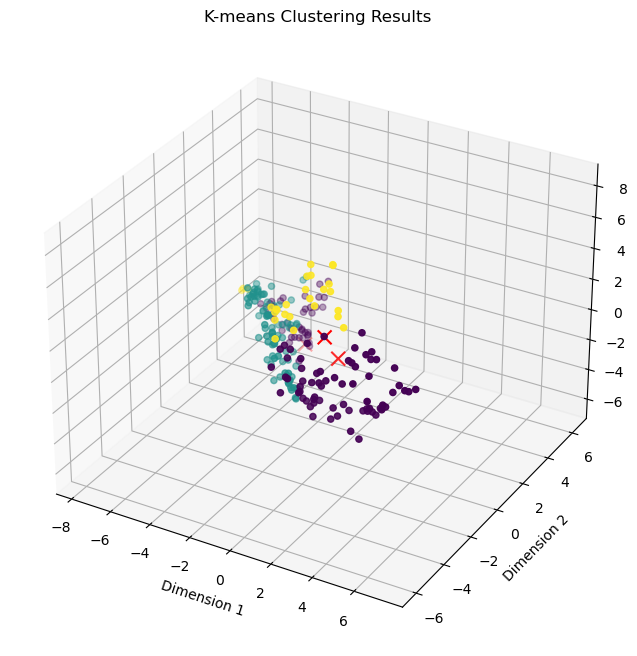

In [475]:

if(reduced_dim == 3):
    # Assuming X_tsne is your data
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the data points
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=labels, cmap='viridis')

    # Plot the cluster centers
    ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', marker='x', s=100)

    # Set labels and title
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    ax.set_title('K-means Clustering Results')

    # Show the plot
    plt.show()
elif(reduced_dim == 2):
    # Plot the data points
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis')

    # Plot the cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100)

    # Set labels and title
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('K-means Clustering Results')

    # Show the plot
    plt.show()


In [476]:
center_of_centers = np.mean(centers, axis=0)

# Assuming X is your data and centers is the array of cluster centers
distances = euclidean_distances(X, centers)
print(centers)

[[-0.25132982 -0.00887983  0.6215222   1.62037037]
 [ 0.39904117  0.02947505 -0.55290774  1.2804878 ]
 [-1.24327883  0.01946191 -0.23611447  1.88888889]]


In [477]:
# Assuming you have the centers and X arrays defined
closest_points = np.argmin(distances, axis=0)
closest_indices = np.arange(len(X))[closest_points]

# Print the closest point and its index for each center
for i, index in enumerate(closest_indices):
    print(f"Center {i+1}: Closest point is at index {index}")

Center 1: Closest point is at index 55
Center 2: Closest point is at index 144
Center 3: Closest point is at index 99


In [478]:
distances.shape,X.shape

((217, 3), (217, 4))

In [479]:
distance_min = np.min(distances, axis=1)
distance_min_idx = np.argmin(distances, axis=1)
df_final['momentum_km'] = distance_min
df_final['momentum_km_idx'] = distance_min_idx
distance_min.shape, distance_min_idx.shape

((217,), (217,))

In [480]:
df_final['momentum_km_sig'] = df_final['momentum_km']
period_length = 15
win_rate_delta_threshold = 0.03
p1_server_win_rate=0
p1_receiver_win_rate=0
p1_server_num=0
p1_receiver_num=0
for i, row in df_final.iterrows():
    if(row['server'] == 1 and row['point_victor'] == 1):
        p1_server_win_rate = p1_server_win_rate+1
    if(row['server'] == 2 and row['point_victor'] == 1):
        p1_receiver_win_rate = p1_receiver_win_rate+1
for i, row in df_final.iterrows():
    if(row['server'] == 1):
        p1_server_num=p1_server_num+1
    if(row['server'] == 2):
        p1_receiver_num=p1_receiver_num+1
p1_server_win_rate = p1_server_win_rate/p1_server_num
p1_receiver_win_rate = p1_receiver_win_rate/p1_receiver_num
print(p1_receiver_win_rate)
print(p1_server_win_rate)
for i, row in df_final.iterrows():
    win_rate_recently=1
    ball_checked=1
    this_server = row['server']
    j=0
    while(j<period_length):
        if(df_final.at[min(i+j+1,len(df_final) - 1), 'server'] == this_server):
            ball_checked = ball_checked+1
            if(df_final.at[min(i+j+1,len(df_final) - 1), 'point_victor'] == 1):
                win_rate_recently = win_rate_recently+1
        if(df_final.at[max(0,i-j-1), 'server'] == this_server):
            ball_checked = ball_checked+1
            if(df_final.at[max(0,i-j-1), 'point_victor'] == 1):
                win_rate_recently = win_rate_recently+1
        j=j+1
    win_rate_recently =win_rate_recently/ball_checked
    if(row['server']==1 and win_rate_recently<p1_server_win_rate-win_rate_delta_threshold):
        df_final.at[i, 'momentum_km_sig'] = -1 * df_final.at[i, 'momentum_km']
        print(i, df_final.at[i, 'momentum_km_sig'], win_rate_recently)
    if(row['server']==2 and win_rate_recently<p1_receiver_win_rate-win_rate_delta_threshold):
        df_final.at[i, 'momentum_km_sig'] = -1 * df_final.at[i, 'momentum_km']
        print(i, df_final.at[i, 'momentum_km_sig'], win_rate_recently)
    

0.2894736842105263
0.6116504854368932
0 -2.035901794699926 0.16
1 -0.7686392433671354 0.12
2 -0.7531742206604112 0.16666666666666666
3 -0.55139801339613 0.13043478260869565
4 -0.6181892310445224 0.18181818181818182
5 -0.4503444512825465 0.19047619047619047
13 -0.8749044094278701 0.2222222222222222
22 -0.6919969029755446 0.2
25 -0.7803818150576539 0.25
26 -0.5845601092197377 0.23076923076923078
60 -0.5484020374360616 0.5333333333333333
61 -2.638298193308132 0.5
67 -0.726179752234809 0.5384615384615384
68 -1.0083729710899314 0.42857142857142855
69 -0.8765942785605351 0.4666666666666667
70 -1.1211228618681814 0.375
71 -0.9148502453458176 0.4375
72 -0.7454628911945369 0.25
74 -0.5455420323585374 0.2222222222222222
76 -0.5269787622931631 0.2222222222222222
78 -0.7050459295468947 0.23529411764705882
82 -0.9650292220844333 0.5
83 -0.9930643488707676 0.5384615384615384
84 -0.8129630757976718 0.5
85 -0.8139641273248844 0.5454545454545454
90 -0.9936670354646281 0.5
91 -0.784653222680815 0.538461

## RF

In [481]:
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [482]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((173, 4), (44, 4), (173,), (44,))

In [483]:
rf = RFR(n_estimators=100, random_state=30)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=30)

In [484]:
rf.predict(X_test)

array([1.13, 1.31, 1.4 , 1.68, 1.79, 1.54, 1.76, 1.21, 1.3 , 1.08, 1.69,
       1.8 , 1.81, 1.55, 1.6 , 1.44, 1.54, 1.5 , 1.28, 1.56, 1.17, 1.32,
       1.75, 1.64, 1.3 , 1.76, 1.63, 1.79, 1.43, 1.77, 1.37, 1.86, 1.42,
       1.36, 1.63, 1.22, 1.58, 1.71, 1.2 , 1.73, 1.79, 1.61, 1.37, 1.75])

In [485]:
y_estimated_rf = rf.predict(X)
df_final['next_point_p1_win_rate'] = y_estimated_rf - 1

In [486]:
df_final['next_point_p1_win_rate'].values.reshape(-1,1).shape

(217, 1)

In [487]:
kmeans_np = KMeans(n_clusters=3, random_state=0)
X_np = df_final['next_point_p1_win_rate'].values.reshape(-1,1)
kmeans_np.fit(X_np)

labels_np = kmeans_np.labels_
centers_np = kmeans_np.cluster_centers_

/Users/yichao/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [488]:
distances_np = euclidean_distances(X_np, centers_np)
distance_min_np = np.min(distances_np, axis=1)
df_final['momentum_km_np'] = distance_min_np

In [489]:
cur_p1_win_as_server = 0
cur_p1_server_count = 0
cur_p1_win_as_receiver = 0
cur_p1_receiver_count = 0
df_final['p1_cur_win_rate_as_server'] = 0
df_final['p1_cur_win_rate_as_receiver'] = 0
for i, row in df_final.iterrows():
    if row['server'] == 1:
        cur_p1_server_count += 1
        if(row['point_victor'] == 1):
            cur_p1_win_as_server += 1
        df_final.at[i, 'p1_cur_win_rate_as_server'] = cur_p1_win_as_server / cur_p1_server_count
    else:
        cur_p1_receiver_count += 1
        if(row['point_victor'] == 1):
            cur_p1_win_as_receiver += 1
        df_final.at[i, 'p1_cur_win_rate_as_receiver'] = cur_p1_win_as_receiver / cur_p1_receiver_count



## eval

In [490]:
from sklearn.metrics import classification_report

y_pred = np.round(rf.predict(X_test)).astype(int)
report = classification_report(y_test, y_pred)

print(report)


              precision    recall  f1-score   support

           1       0.61      0.44      0.51        25
           2       0.46      0.63      0.53        19

    accuracy                           0.52        44
   macro avg       0.54      0.54      0.52        44
weighted avg       0.55      0.52      0.52        44



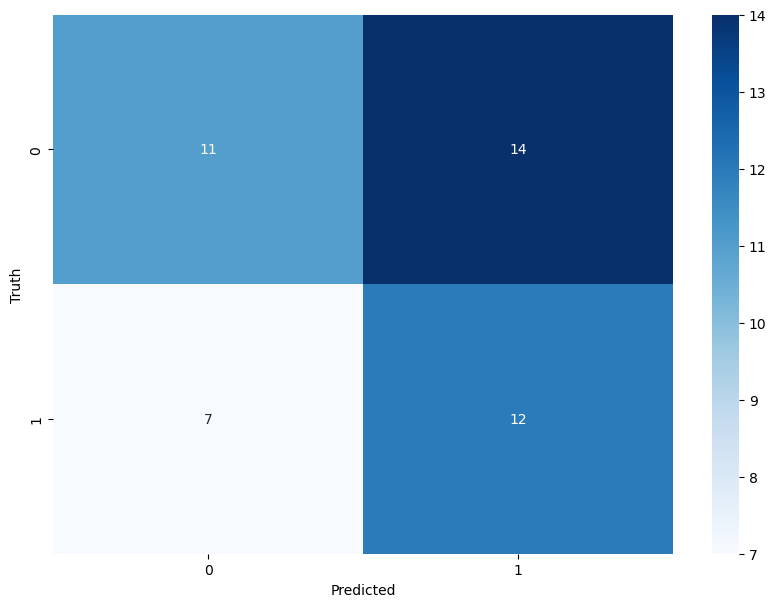

In [491]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Use seaborn to plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [492]:
calculateMetrics(y_test, np.round(rf.predict(X_test)))

RMSE: 0.6908492797077574
MAE: 0.4772727272727273
MAPE: 0.2121212121212121
R2: -0.9452631578947372
Pearson correlation coefficient: 0.07211227313725484
Spearman correlation coefficient: 0.07211227313725482


(0.6908492797077574,
 0.4772727272727273,
 0.2121212121212121,
 -0.9452631578947372,
 0.07211227313725484,
 0.07211227313725482)

In [493]:
# import matplotlib.pyplot as plt

# # 计算特征重要程度
# importances = rf.feature_importances_

# # 创建一个Series对象，将特征名称和对应的重要程度值组合起来
# # importances = importances.reshape(len(NP_relevant_columns))
# # importances = importances.reshape(pca_dim)
# # importances = importances.reshape(3)
# # feature_importances = pd.Series(importances.mean(axis=1), index=NP_relevant_columns)
# feature_importances = pd.Series(importances, index=NP_relevant_columns)
# # feature_importances = pd.Series(importances, index=[f'pca_{i}' for i in range(pca_dim)])
# # feature_importances = pd.Series(importances, index=[f'pca_{i}' for i in range(3)])

# # 按照重要程度降序排列
# feature_importances = feature_importances.sort_values(ascending=False)

# # 可视化特征重要程度
# plt.figure(figsize=(10, 6))
# feature_importances.plot(kind='bar')
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('Feature Importance in Random Forest')
# plt.show()


## Momentum 

In [494]:
df_final['momentum_rf'] = 0
for i, row in df_final.iterrows():
    if(row['server'] == 1):
        df_final.at[i, 'momentum_rf'] = df_final.at[i, 'p1_cur_win_rate_as_server'] - df_final.at[i, 'next_point_p1_win_rate']
    else:
        df_final.at[i, 'momentum_rf'] = df_final.at[i, 'p1_cur_win_rate_as_receiver'] - df_final.at[i, 'next_point_p1_win_rate']

In [495]:
def plot_momentum(method, diff=0, set=True, game=True, break_point=True, ave_window=10, isKM=False, isSig=False, showOriginal=True, normalize='sigmoid'):
    figsize = (20, 10)
    if(isSig == True):
        method = 'momentum_' + method + '_sig'
        plot_title = "Player Momentum"
    else:
        method = 'momentum_' + method 
        plot_title = "Flow of Match (Importance of Points)"
    if(normalize == 'minmax'):
        df_final['momentum_normalized'] = (df_final[method] - df_final[method].min()) / (df_final[method].max() - df_final[method].min())
        mid_value = (df_final[method].max() + df_final[method].min()) / 2
    elif(normalize == 'zscore'):
        df_final['momentum_normalized'] = (df_final[method] - df_final[method].mean()) / df_final[method].std()
        mid_value = 0
    else: # (normalize == 'sigmoid')
        df_final['momentum_normalized'] = 1 / (1 + np.exp(-df_final[method]))
        mid_value = 0.5

    if(isSig == True):
        plt.axhline(y=mid_value, color='r', linestyle='-')

    df_final['momentum_normalized_average'] = df_final['momentum_normalized'].rolling(window=ave_window, min_periods=1).mean()
    # df_final['momentum_normalized'] = (df_final[method] - df_final[method].mean()) / df_final[method].std()

    # Add more scatter plots for game_victor, set_victor, but only for points not zero
    set_end_idx_p1 = []
    set_end_idx_p2 = []
    game_end_idx_p1 = []
    game_end_idx_p2 = []
    bk_idx_p1 = []
    bk_idx_p2 = []
    for i, row in df_final.iterrows():
        if row['set_victor'] == 1:
            set_end_idx_p1.append(i)
        elif row['set_victor'] == 2:
            set_end_idx_p2.append(i)
        if row['game_victor'] == 1:
            game_end_idx_p1.append(i)
        elif row['game_victor'] == 2:
            game_end_idx_p2.append(i)
        if row['p1_break_pt_won'] == 1:
            bk_idx_p1.append(i)
        elif row['p2_break_pt_won'] == 2:
            bk_idx_p2.append(i)

    # Extract y-values for set_end_idx and game_end_idx
    set_end_y_p1 = df_final.loc[set_end_idx_p1, 'momentum_normalized']
    set_end_y_p2 = df_final.loc[set_end_idx_p2, 'momentum_normalized']
    game_end_y_p1 = df_final.loc[game_end_idx_p1, 'momentum_normalized']
    game_end_y_p2 = df_final.loc[game_end_idx_p2, 'momentum_normalized']
    bk_y_p1 = df_final.loc[bk_idx_p1, 'momentum_normalized']
    bk_y_p2 = df_final.loc[bk_idx_p2, 'momentum_normalized']

    set_end_y_p1_ave = df_final.loc[set_end_idx_p1, 'momentum_normalized_average']
    set_end_y_p2_ave = df_final.loc[set_end_idx_p2, 'momentum_normalized_average']
    game_end_y_p1_ave = df_final.loc[game_end_idx_p1, 'momentum_normalized_average']
    game_end_y_p2_ave = df_final.loc[game_end_idx_p2, 'momentum_normalized_average']
    bk_y_p1_ave = df_final.loc[bk_idx_p1, 'momentum_normalized_average']
    bk_y_p2_ave = df_final.loc[bk_idx_p2, 'momentum_normalized_average']
    if(showOriginal == True):
        df_final['momentum_normalized'].plot(figsize=figsize)
        # Add scatter plots
        if(game == True):
            plt.scatter(game_end_idx_p1, game_end_y_p1, color='g', label='P1 win a game')
            plt.scatter(game_end_idx_p2, game_end_y_p2, color='y', label='P2 win a game')
        if(break_point == True):
            plt.scatter(bk_idx_p1, bk_y_p1, color='m', label='Break Point P1')
            plt.scatter(bk_idx_p2, bk_y_p2, color='c', label='Break Point P2')
        if(set == True):
            plt.scatter(set_end_idx_p1, set_end_y_p1, color='r', label='P1 win a set')
            plt.scatter(set_end_idx_p2, set_end_y_p2, color='b', label='P2 win a set') 
    else:
        # Add scatter plots
        if(game == True):
            plt.scatter(game_end_idx_p1, game_end_y_p1_ave, color='g', label='P1 win a game')
            plt.scatter(game_end_idx_p2, game_end_y_p2_ave, color='y', label='P2 win a game')
        if(break_point == True):
            plt.scatter(bk_idx_p1, bk_y_p1_ave, color='m', label='Break Point P1')
            plt.scatter(bk_idx_p2, bk_y_p2_ave, color='c', label='Break Point P2')
        if(set == True):
            plt.scatter(set_end_idx_p1, set_end_y_p1_ave, color='r', label="P1 win a set")
            plt.scatter(set_end_idx_p2, set_end_y_p2_ave, color='b', label="P2 win a set")
    df_final['momentum_normalized_average'].plot(figsize=figsize)
    
    if(isKM == True):
        # closest_indices_y = df_final.loc[closest_indices, 'momentum_normalized']
        # plt.scatter(closest_indices, closest_indices_y, color='k', label='KM')
        for i, row in df_final.iterrows():
            if(row['momentum_km_idx'] == 0):
                plt.scatter(i, df_final.at[i, 'momentum_normalized'], color='k')
            elif(row['momentum_km_idx'] == 1):
                plt.scatter(i, df_final.at[i, 'momentum_normalized'], color='g')
            elif(row['momentum_km_idx'] == 2):
                plt.scatter(i, df_final.at[i, 'momentum_normalized'], color='y')
            # elif(row['momentum_km_idx'] == 3):
            #     plt.scatter(i, df_final.at[i, 'momentum_normalized'], color='m')

    plt.xlabel('Points')
    plt.ylabel('Density')
    plt.title(plot_title)
    plt.legend()
    plt.show()

In [496]:
def plot_tennis_scores(df):
    fig, axs = plt.subplots(5, 1, figsize=(10, 20))

    levels = ['Point', 'Game', 'Set', 'Score_diff']
    score_cols_p1 = ['p1_score', 'p1_games', 'p1_sets', 'p1_points_won']
    score_cols_p2 = ['p2_score', 'p2_games', 'p2_sets', 'p2_points_won']

    for i, ax in enumerate(axs[:-1]):
        ax.plot(df[score_cols_p1[i]], label='Player 1')
        ax.plot(df[score_cols_p2[i]], label='Player 2')
        ax.set_xlabel('Time')
        ax.set_ylabel('Score')
        ax.set_title(f'{levels[i]} Scores')
        ax.legend()

    # For match score, we can't directly plot p1_sets and p2_sets, 
    # as they will overlap and not give a clear picture of who is leading the match.
    # Instead, we plot the difference between p1_sets and p2_sets.
    axs[-1].plot(df['p1_points_won'] - df['p2_points_won'], label='p2 Score')
    axs[-1].set_xlabel('Time')
    axs[-1].set_ylabel('Score Difference')
    axs[-1].set_title('Match Scores')
    axs[-1].legend()

    plt.tight_layout()
    plt.show()

# plot_tennis_scores(df_final)

In [497]:
# plot_momentum('km_np', break_point=False, ave_window=15)

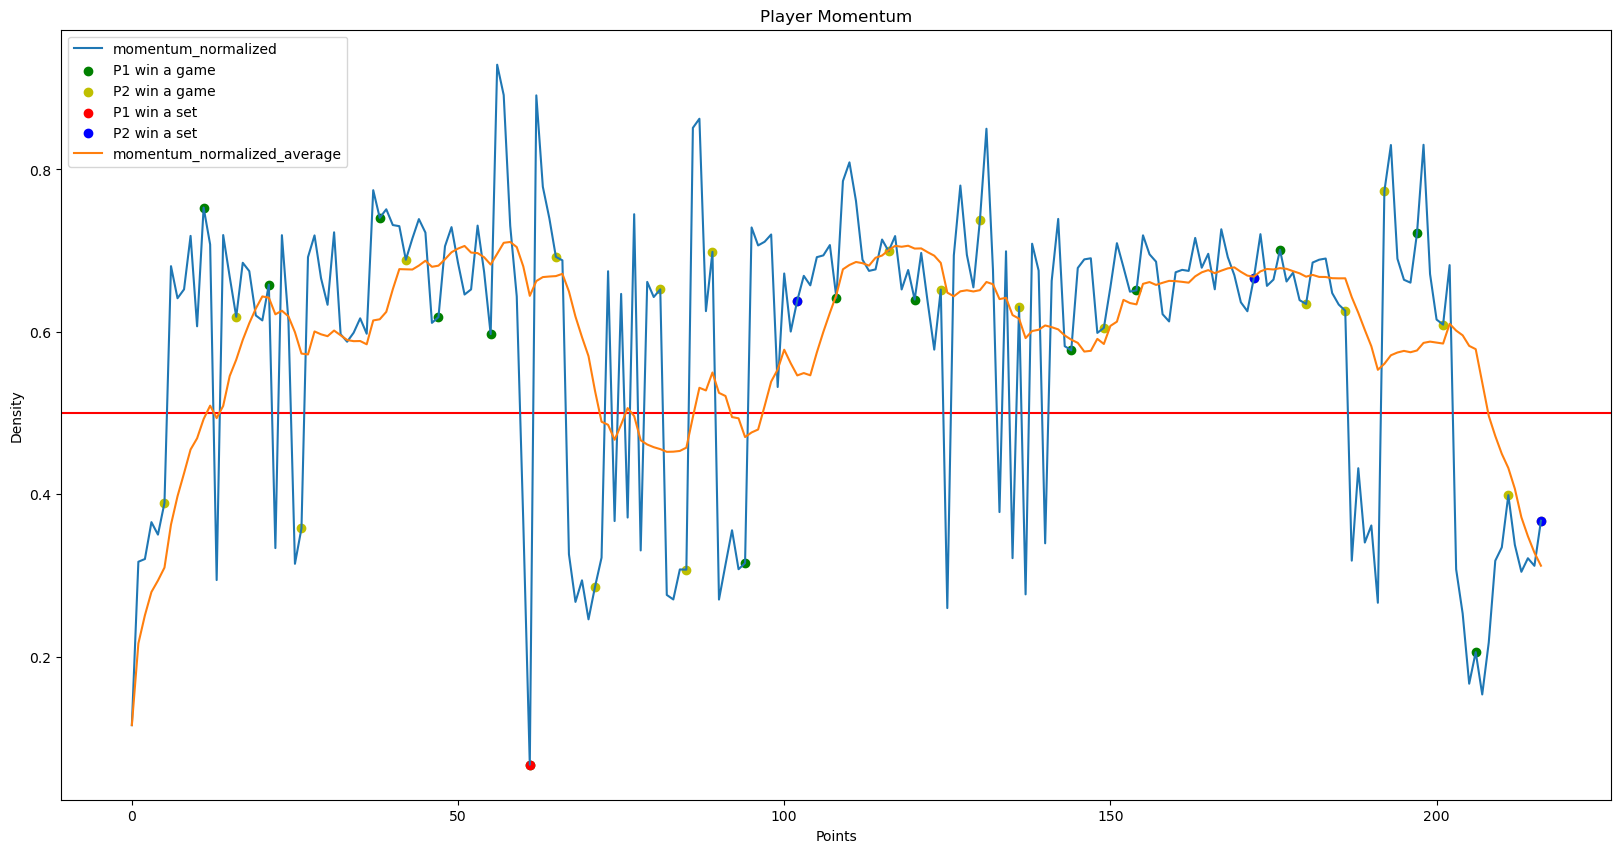

In [498]:
plot_momentum('km', break_point=False, ave_window=15, isSig=True, showOriginal=True)

In [499]:
# plot_momentum('km', break_point=False, ave_window=15, isSig=False)

我笼统地理解为，大体上所有点的特征向量是趋同的（存疑），聚类能很好地捕捉这种趋同的性质。如果某个点越“鹤立鸡群”（即离中心点距离远），越不与其他点趋同，说明此时该点越是比赛的关键点。我赋予这样的点更大的值，从而捕捉到比赛的关键转折点。反应在图像上就是波峰波谷。

In [500]:
# plot_momentum('rf', break_point=False, ave_window=15)

In [501]:
# df_final[["game_victor", "set_victor", "momentum_normalized_average"]].to_csv(f'../data/Wimbledon_featured_matches_modified_add_features_with_momentum_{match_id}.csv', index=False)

In [502]:
df_final.to_csv(f'../data/Wimbledon_featured_matches_modified_add_features_with_momentum_{match_id}.csv', index=False)